In [1]:
# https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net

In [49]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import cv2
import pdb
import time, warnings
import collections
import random
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
DATASET_PATH = "/media/2/hwbae0326/Kaggle/sartorius/dataset/"

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
fix_all_seeds(2021)

In [4]:
TRAIN_CSV = DATASET_PATH+"train.csv"
df_train = pd.read_csv(DATASET_PATH+"train.csv")
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [5]:
SAMPLE_SUBMISSION  = DATASET_PATH+'/sample_submission.csv'
TRAIN_CSV = DATASET_PATH+"/train.csv"
TRAIN_PATH = DATASET_PATH+"/train"
TEST_PATH = DATASET_PATH+"/test"

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

# (336, 336)
IMAGE_RESIZE = (224, 224)

LEARNING_RATE = 5e-3
EPOCHS = 12


In [6]:
data_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize(IMAGE_RESIZE),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=RESNET_MEAN, std=RESNET_STD),
                ])
mask_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize(IMAGE_RESIZE),
                    transforms.ToTensor(),
                    #transforms.Normalize(mean=RESNET_MEAN, std=RESNET_STD),
                ])
TranForm = [data_transforms, mask_transforms]

In [7]:
# run-length decoding
#    mask_rle: run-length as string formated (start length)
#    shape: (height,width) of array to return 
#    Returns numpy array, 1 - mask, 0 - background
def rle_decode(mask_rle, shape, color=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -=1
    ends = starts+lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

In [8]:
class CellDataset(Dataset):
    def __init__(self, df, base_path, transform):
        self.df = df
        self.base_path = base_path
        self.transforms = transform
        self.gb = self.df.groupby('id')
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)
        annotations = df['annotation'].tolist()
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)
        #print(image.shape)
        mask = build_masks(df_train, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        #print(mask.shape)
        augmented = {'image' : image, 'mask' : mask}
        
        augmented['image'] = self.transforms[0](image)
        augmented['mask'] = self.transforms[1](mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.image_ids)

In [9]:
ds_train = CellDataset(df_train,TRAIN_PATH,TranForm)

In [10]:
image, mask = ds_train[1]
image.shape, mask.shape

/media/2/hwbae0326/anaconda3/envs/kaggle/lib/python3.7/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

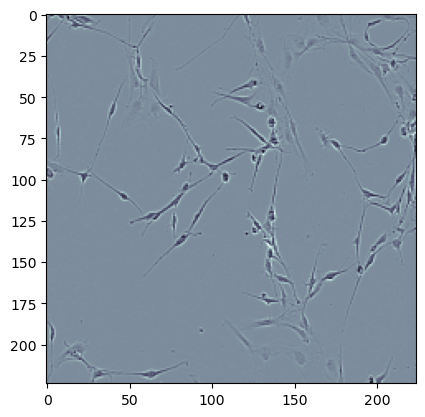

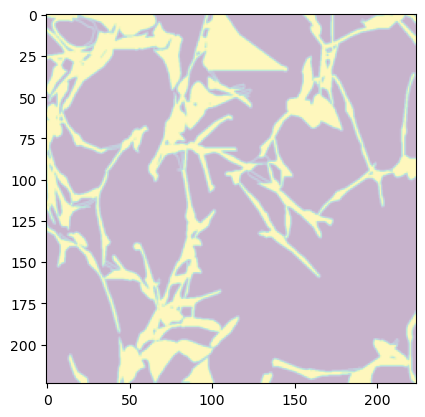

In [11]:
plt.imshow(image[0], cmap='bone')
plt.show()
plt.imshow(mask[0], alpha=0.3)
plt.show()

In [12]:
#torch.multiprocessing.set_start_method('spawn')
dl_train = DataLoader(ds_train, batch_size=64, num_workers=0, pin_memory=True, shuffle=False)


In [13]:
batch = next(iter(dl_train))
images, masks = batch

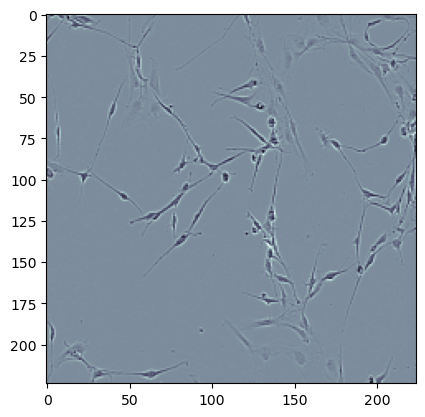

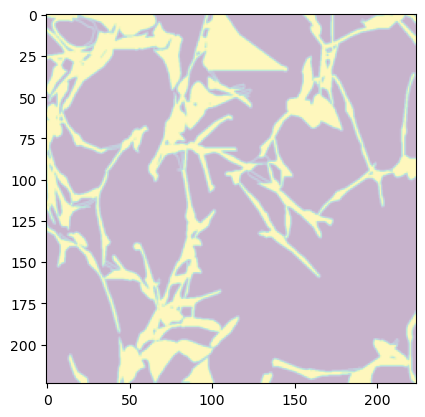

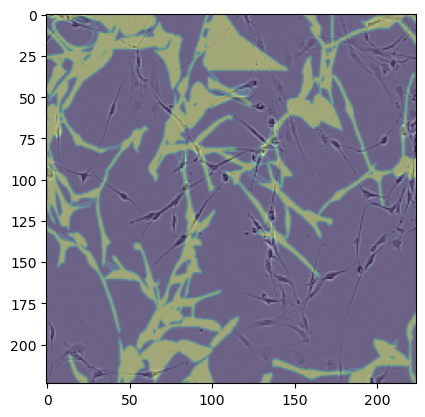

In [14]:
idx=1
plt.imshow(images[idx][0], cmap='bone')
plt.show()
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()

In [15]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    #print(iflat,tflat)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target*2.0 -1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
    def forward(self, input, target):
        loss = self.alpha * self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained='imagenet').cuda()
print(model)

In [57]:
for para in model.parameters():
    if para.requires_grad is False:
        print("false")

In [25]:
#import collections.abc as container_abcs
#torch._six.container_abcs = container_abcs

In [53]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(dl_train)

model.cuda()
model.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(dl_train):
        
        # Predict
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

Starting epoch: 1 / 12
Epoch: 1 - Train Loss 3.4952
Starting epoch: 2 / 12
Epoch: 2 - Train Loss 3.4926
Starting epoch: 3 / 12
Epoch: 3 - Train Loss 3.4924
Starting epoch: 4 / 12
Epoch: 4 - Train Loss 3.4923
Starting epoch: 5 / 12
Epoch: 5 - Train Loss 3.4923
Starting epoch: 6 / 12
Epoch: 6 - Train Loss 3.4923
Starting epoch: 7 / 12
Epoch: 7 - Train Loss 3.4923
Starting epoch: 8 / 12
Epoch: 8 - Train Loss 3.4923
Starting epoch: 9 / 12


KeyboardInterrupt: 

In [58]:
class TestCellDataset(Dataset):
    def __init__(self):
        self.test_path = TEST_PATH
        
        # I am not sure if they adapt the sample submission csv or only the test folder
        # I am using the test folders as the ground truth for the images to predict, which should be always right
        # The sample csv is ignored
        self.image_ids = [f[:-4]for f in os.listdir(self.test_path)]
        self.num_samples = len(self.image_ids)
        self.transform = TranForm[1]

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        path = os.path.join(self.test_path, image_id + ".png")
        image = cv2.imread(path)
        image = self.transform(image)
        return {'image': image, 'id': image_id}

    def __len__(self):
        return self.num_samples

In [59]:
#del dl_train, ds_train, optimizer

In [60]:
#del dl_train, ds_train, optimizer
ds_test = TestCellDataset()
dl_test = DataLoader(ds_test, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [61]:
def post_process(probability, threshold=0.5, min_size=300):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros((520, 704), np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions

# Stolen from: https://www.kaggle.com/arunamenon/cell-instance-segmentation-unet-eda
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# Modified by me
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [62]:
model.eval()
model.cuda()
submission = []
predicted = []
for i, batch in enumerate(tqdm(dl_test)):
    preds = torch.sigmoid(model(batch['image'].cuda()))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for image_id, probability_mask in zip(batch['id'], preds):
        try:
            #if probability_mask.shape != IMAGE_RESIZE:
            #    probability_mask = cv2.resize(probability_mask, dsize=IMAGE_RESIZE, interpolation=cv2.INTER_LINEAR)
            probability_mask = cv2.resize(probability_mask, dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
            predictions = post_process(probability_mask)
            for prediction in predictions:
                #plt.imshow(prediction)
                #plt.show()
                predicted.append(prediction)
                try:
                    submission.append((image_id, rle_encoding(prediction)))
                except:
                    print("Error in RL encoding")
        except Exception as e:
            print(f"Exception for img: {image_id}: {e}")
        
        # Fill images with no predictions
        image_ids = [image_id for image_id, preds in submission]
        if image_id not in image_ids:
            submission.append((image_id, ""))

/media/2/hwbae0326/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
submission

[('d48ec7815252', '1 366080'),
 ('d8bfd1dafdc4', '1 366080'),
 ('7ae19de7bc2a', '1 366080')]

In [63]:
len(predicted)

3

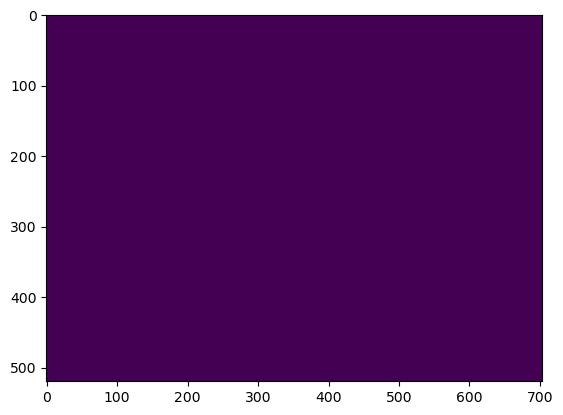

In [64]:
plt.imshow(predicted[1])
plt.show()

In [ ]:
predicted[0].shape

NoneType